# Mandelbrot Multi-Layer Perceptron Model

In this notebook, we are going to define an MLP model that we will use to infer if a coordinate belongs to the Mandelbrot set.

## 🛠️ Supported Hardware

This notebook can run in a CPU or in a GPU.

✅ AMD Instinct™ Accelerators  
✅ AMD Radeon™ RX/PRO Graphics Cards  
✅ AMD EPYC™ Processors  
✅ AMD Ryzen™ (AI) Processors  

Suggested hardware: **AI PC powered by AMD Ryzen™ AI Processors**

## ⚡ Recommended Software Environment

::::{tab-set}

:::{tab-item} Linux
- [Install Docker container](https://amdresearch.github.io/aup-ai-tutorials//env/env-gpu.html)
- [Install PyTorch](https://amdresearch.github.io/aup-ai-tutorials//env/env-cpu.html)
:::

:::{tab-item} Windows
- [Install Direct-ML](https://amdresearch.github.io/aup-ai-tutorials//env/env-gpu-windows.html)
- [Install PyTorch](https://amdresearch.github.io/aup-ai-tutorials//env/env-cpu.html)
:::
::::

## 🎯 Goals

- Define a multi-layer perceptron (MLP) model to classify coordinates in the Mandelbrot set.
- Train the model on a dataset of coordinates.
- Evaluate the model's performance on a test set.

## Define the model

The input to this model is two a coordinate in two dimensions (x, y). this coordinate is fed to 56 neurons. Then followed by a second hidden layer with 40 neurons. Finally, the last layer is a single neuron that indicates if the coordinate is part of the mandelbrot set. Between the the linear layers, the sigmoid function is used as activation.

In [1]:
import torch

class Mandelbrot(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(2, 56)
        self.fc2 = torch.nn.Linear(56, 40)
        self.fc3 = torch.nn.Linear(40, 1)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x1 = self.fc1(x)
        x2 = self.sigmoid(x1)
        x3 = self.fc2(x2)
        x4 = self.sigmoid(x3)
        x5 = self.fc3(x4)
        output = self.sigmoid(x5)
        return output

Instantiate and show model. Note how the linear layers have bias enabled by default.

In [2]:
model = Mandelbrot()
print(model)

Mandelbrot(
  (fc1): Linear(in_features=2, out_features=56, bias=True)
  (fc2): Linear(in_features=56, out_features=40, bias=True)
  (fc3): Linear(in_features=40, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


We can run inference with an untrained model using a single coordinate or multiple coordinates.

In [3]:
input = torch.tensor([0.5, 0.6])
with torch.no_grad():
    output = model(input.unsqueeze(0)) # Run the model with batch 1
print(output)

tensor([[0.6144]])


In [4]:
input_data = torch.randn(8, 2)  # batch of 2D tensors batchsize is 8
with torch.no_grad():
    output = model(input_data) # run the model batchsize=8
print(output)

tensor([[0.6097],
        [0.6116],
        [0.6112],
        [0.6141],
        [0.6118],
        [0.6151],
        [0.6129],
        [0.6101]])


Find out more information about the different layers in this model.

In [44]:
from torchinfo import summary
summary(model, input_size=(1, 2), col_names=["input_size", "output_size", "num_params", "mult_adds", "trainable"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Mult-Adds                 Trainable
Mandelbrot                               [1, 2]                    [1, 1]                    --                        --                        True
├─Linear: 1-1                            [1, 2]                    [1, 56]                   168                       168                       True
├─Sigmoid: 1-2                           [1, 56]                   [1, 56]                   --                        --                        --
├─Linear: 1-3                            [1, 56]                   [1, 40]                   2,280                     2,280                     True
├─Sigmoid: 1-4                           [1, 40]                   [1, 40]                   --                        --                        --
├─Linear: 1-5                            [1, 40]                   [1, 1]                    41    

## Check Model Topology with Netron (Optional)

In [ ]:
onnx_path = "datasets/mandelbrot/model.onnx"
torch.onnx.export(model.to('cpu'), input.to('cpu').unsqueeze(0), onnx_path)

In [6]:
import netron
import IPython
port = 8000
netron.start(onnx_path, port, browse=False)

IPython.display.IFrame(f"http://localhost:{port}", width=400, height=750)

Serving 'model.onnx' at http://localhost:8000


## Create Train, Validation and Test Data

Using the Mandelbrot set trained in the previous notebook, we are going to create a dataset that can be used to train our model.

The coordinates in the range -2 to 1 (x) and -1.5 to 1.5 (y) are the input to our model. We would like to train our MLP model to classify if a point belongs to the Mandelbrot set or not.

We need to transform the 2D image into a dataset that can be used to train the dataset, for this we will create a list that contains all pairs of coordinates.

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

mandelbrot_golden = np.load('datasets/mandelbrot/mandelbrot-set_200_200.npy')

# Translate pixel positions to coordinates in x, y in the given range
x = np.linspace(-2, 1, mandelbrot_golden.shape[1]) 
y = np.linspace(-1.5, 1.5, mandelbrot_golden.shape[0])
xx, yy = np.meshgrid(x, y) #Create a meshgrid of indices

# Create a list of coordinates and corresponding values
coordinates = np.vstack((xx.flatten(), yy.flatten())).T
values = mandelbrot_golden.flatten()

Use the GPU is available

In [8]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'{device=}')

device=device(type='cpu')


First, we will use `train_test_split` from `sklearn` to randomly separate our dataset in 80% points for training, 10% for validation and 10% for test.

Then, we are going to create the `DataLoader`s that we use in the training step. 

In [9]:
# Split data into training and test sets (80% training, 20% test)
train_coords, test_coords, train_values, test_values = train_test_split(coordinates, values, test_size=0.2, random_state=42)
# Split test set into validation and test sets (50% validation, 50% test)
val_coords, test_coords, val_values, test_values = train_test_split(test_coords, test_values, test_size=0.5, random_state=42)

# Convert data to PyTorch tensors and move to device (GPU if available)
train_coords = torch.from_numpy(train_coords).float().to(device)
val_coords = torch.from_numpy(val_coords).float().to(device)
test_coords = torch.from_numpy(test_coords).float().to(device)

train_values = torch.from_numpy(train_values).float().to(device)
val_values = torch.from_numpy(val_values).float().to(device)
test_values = torch.from_numpy(test_values).float().to(device)

# Create datasets
train_dataset = TensorDataset(train_coords, train_values)
val_dataset = TensorDataset(val_coords, val_values)
test_dataset = TensorDataset(test_coords, test_values)

print(f'{len(train_dataset)=}\n{len(val_dataset)=}\n{len(test_dataset)=}')

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

len(train_dataset)=32000
len(val_dataset)=4000
len(test_dataset)=4000


## Train the Model

We the datasets ready, now we can turn our attention to train the model. We will cover some of the basic, for more information refer to [Pytorch training](https://pytorch.org/tutorials/beginner/introyt/trainingyt.html)

We will start by initializing the weights and bias to a known value. We do this to be able to compare how different hyperparameters affect the accuracy of our model.

In [10]:
def init_weights(m):
    if type(m) == torch.nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

model.apply(init_weights)

Mandelbrot(
  (fc1): Linear(in_features=2, out_features=56, bias=True)
  (fc2): Linear(in_features=56, out_features=40, bias=True)
  (fc3): Linear(in_features=40, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Let us now define our training algorithm.

1. We use Binary Cross Entropy as loss function as we are doing a binary classification.
1. We use the Adam algorithm as optimization, we set the learning rate to `0.003`.
1. We will run for 600 epochs. You can increase this number.
1. Note that each time we find a new minimum loss, we save the model.

```{note}
Training the model should take around 10 minutes. You should expect a validation loss of around `0.02`.
```

In [ ]:
import warnings

loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
epochs = 600

best_validation = np.finfo(np.float32).max
model_checkpoint = 'datasets/mandelbrot/tmp_model.pt'
len_train_loader = len(train_loader)
len_val_loader = len(val_loader)

validation_loss_list = []
training_loss_list = []

model.to(device) # move the model to GPU if available

for epoch in range(epochs):
    training_loss = 0
    model.train()  # Set the model to training mode
    for inputs, targets in train_loader:
        model.train(True)
        # Forward pass
        outputs = model(inputs)
        loss = loss_fn(outputs, targets.unsqueeze(1))
        training_loss += loss.item()
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    training_loss /= len_train_loader

    # Validation
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # No need to track gradients
        val_loss = 0
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = loss_fn(outputs, targets.unsqueeze(1))
            val_loss += loss.item()
        val_loss /= len_val_loader

    if epoch % 50 == 0 or epoch == epochs - 1:
        print(f'Epoch {epoch+1:4d}/{epochs}, training loss: {training_loss:.12f}, '
              f'validation loss: {val_loss:.12f}')
    validation_loss_list.append(val_loss)
    training_loss_list.append(training_loss)
    if best_validation > val_loss:
        try:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'validation_loss': val_loss,
                'training_loss': training_loss,
                }, model_checkpoint)
            best_validation = val_loss
        except RuntimeError:
            warnings.warn(f'Unable to save checkpoint for epoch {epoch}'
                          f'and validation loss {val_loss}')

Epoch    1/600, training loss: 0.390668754086, validation loss: 0.384935115576
Epoch   51/600, training loss: 0.037902400194, validation loss: 0.040682048915
Epoch  101/600, training loss: 0.030075405075, validation loss: 0.031245074775
Epoch  151/600, training loss: 0.027869399881, validation loss: 0.030764960987
Epoch  201/600, training loss: 0.026233200431, validation loss: 0.028096317649
Epoch  251/600, training loss: 0.025226899117, validation loss: 0.026731093964
Epoch  301/600, training loss: 0.024251417724, validation loss: 0.025377916938
Epoch  351/600, training loss: 0.023816803444, validation loss: 0.023789182591
Epoch  401/600, training loss: 0.021896260432, validation loss: 0.023105285909
Epoch  451/600, training loss: 0.020030394189, validation loss: 0.022491329535
Epoch  501/600, training loss: 0.018849210041, validation loss: 0.021783229207
Epoch  551/600, training loss: 0.018184235374, validation loss: 0.020037012069
Epoch  600/600, training loss: 0.017922980564, valid

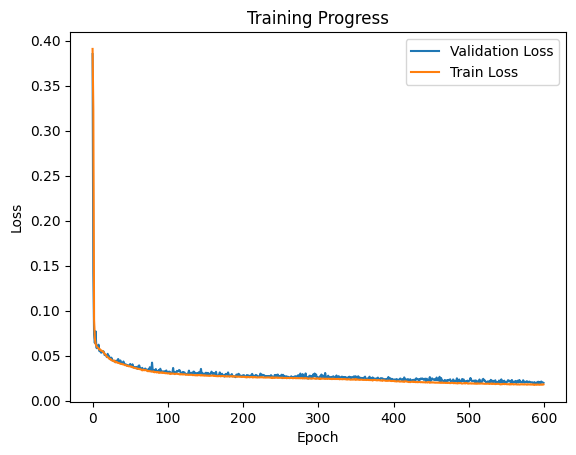

In [13]:
import matplotlib.pyplot as plt

plt.plot(validation_loss_list, label='Validation Loss')
plt.plot(training_loss_list, label='Train Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Progress")
plt.legend(loc="upper right")

plt.show()

```{note}
The validation loss tracks the train loss and we do not see a divergence, which means that the model is not [overfitting](https://www.kaggle.com/code/ryanholbrook/overfitting-and-underfitting).
```

Load the model with the minimum loss, and check loss against test set.

In [ ]:
checkpoint = torch.load(model_checkpoint, weights_only=True)
print(f'Loading best training from checkpoint. Epoch: {checkpoint["epoch"]}, '
      f'validation loss: {checkpoint["validation_loss"]}, '
      f'training loss {checkpoint["training_loss"]}')
model.load_state_dict(checkpoint['model_state_dict'])

len_test_loader = len(test_loader)
# Testing
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # No need to track gradients
    test_loss = 0
    for inputs, targets in test_loader:
        outputs = model(inputs)
        loss = loss_fn(outputs, targets.unsqueeze(1))
        test_loss += loss.item()
    test_loss /= len_test_loader

print(f'Test Loss: {test_loss}')

Loading best training from checkpoint. Epoch: 586, validation loss: 0.018614342340861185, training loss 0.017971204951190912
Test Loss: 0.019255705687253794


Let us save the final trained model.

In [ ]:
torch.save(model.state_dict(), 'datasets/mandelbrot/myfirst_trained_model.pt')

## Reproduce Mandelbrot Using Trained Model

After we trained a model and we are satisfied with the accuracy, let's visually see what is the result of when we use the model instead of the actual formula. We will create an empty image as well as the x and y coordinates

In [15]:
img_model = np.zeros((mandelbrot_golden.shape[0], mandelbrot_golden.shape[1]), dtype=np.float32)
x_values = np.linspace(-2, 1, img_model.shape[1])
y_values = np.linspace(-1.5, 1.5, img_model.shape[0])

We iterate over x and y coordinates one by one to get the predicted output from the model

In [16]:
model.to('cpu')
with torch.no_grad():
    for idx, xval in enumerate(x_values):
        for idy, yval in enumerate(y_values):
            input_tensor = torch.tensor([xval, yval], dtype=torch.float32)
            output = model(input_tensor.unsqueeze(0))
            img_model[idy, idx] = output.item()

## Model Accuracy

We can compute the model accuracy, for this we will count coordinates where the trained model gives the exact answer. 

In [17]:
accuracy = np.count_nonzero(np.isclose(mandelbrot_golden, img_model)) / mandelbrot_golden.size
print(f'Model accuracy {accuracy*100: .2f}%')

Model accuracy  64.85%


## Visualize Output of the Trained Model

Although the accuracy is short of 60%, if we check the results visually you can see that for most part the results are correct, however the model struggles in the transitions.

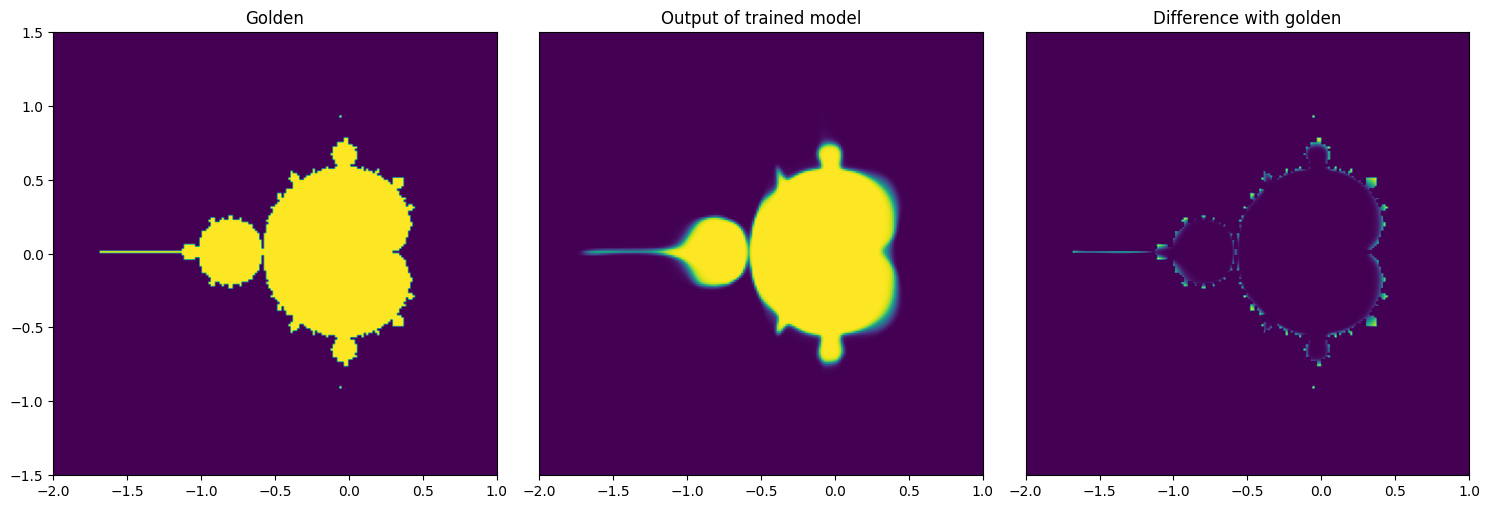

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 8))
axes[0].imshow(mandelbrot_golden, extent=(x_values[0], x_values[-1], y_values[0], y_values[-1]), origin='lower', vmin=0, vmax=1);
axes[0].set_title('Golden');
axes[1].imshow(img_model, extent=(x_values[0], x_values[-1], y_values[0], y_values[-1]), origin='lower', vmin=0, vmax=1);
axes[1].set_title('Output of trained model');
axes[1].get_yaxis().set_visible(False)
axes[2].imshow(mandelbrot_golden-img_model, extent=(x_values[0], x_values[-1], y_values[0], y_values[-1]), origin='lower', vmin=0, vmax=1);
axes[2].set_title('Difference with golden');
axes[2].get_yaxis().set_visible(False)
fig.tight_layout()

----------
Copyright (C) 2025 Advanced Micro Devices, Inc. All rights reserved. Portions of this file consist of AI-generated content.

SPDX-License-Identifier: MIT